In [2]:

import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
%matplotlib inline

import seaborn as sns

import sklearn
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import sklearn.gaussian_process as gp
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV, train_test_split
#from sklearn.inspection import plot_partial_dependence
from sklearn.utils.extmath import cartesian
from sklearn.inspection._partial_dependence import _grid_from_X
from sklearn.inspection._partial_dependence import _partial_dependence_recursion
from sklearn.inspection._partial_dependence import _partial_dependence_brute
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import skopt
from skopt.learning import ExtraTreesRegressor as opt_ETR
from skopt.learning import RandomForestRegressor as opt_RFR

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import norm

import shap

import sys, os
sys.dont_write_bytecode = True

import pickle
import itertools

import conditions, gen_data, analysis

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

PATH = 'Output_Figures'
os.makedirs(PATH, exist_ok=True)

PATH2 = 'Output_CSV'
os.makedirs(PATH2, exist_ok=True)

In [11]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']

pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']

converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[1,1,1], idx=None)
data = converted['data']
feat, target = converted['feat'], converted['target']
target_name = condition['target_name']
feat_cols = feat.columns

desc = converted['desc']
desc_cols = conditions.desc_columns(Reaction)
basic_desc = desc_cols['basic_desc_columns']
pgm_plus_ReAu = desc_cols['pgm_plus_ReAu']
noble_gas = desc_cols['noble_gas']
drop_elems = desc_cols['drop_elems']
all_drop_elems = pgm_plus_ReAu + noble_gas + drop_elems
desc = desc[basic_desc]

desc_cand_list = [
    'Group', 'EN_Allred', 'm.p.',
    'd_fus_H', 'Density', 'Eads_CO2',
    'BG_Oxide', 'Ox Num_Oxide'
    ]

desc = desc[desc_cand_list]
desc = desc.drop(all_drop_elems)

model  = ExtraTreesRegressor(n_estimators = 100, random_state = 1107, n_jobs = -1)
model.fit(feat, target)

20220318 rwgs_250 all data


ExtraTreesRegressor(n_jobs=-1, random_state=1107)

In [4]:
def custom_oneway_pdp(
    target_feat, feat, target, model, expand_rate=0.1, grid_resolution=100, cmap_color='bwr',
    max_wt=10, max_target='auto', min_target='auto', max_feat='auto', min_feat='auto', plot=False, number=False
    ):

    if Reaction == 'rwgs_250' or Reaction == 'rwgs_250_1wt' or Reaction == 'rwgs_300':
        label_name = 'CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)'

    elif Reaction == 'CH3OH':
        label_name = '$CH_{3}OH$ formation rate (mmol $g^{{-}1}$ $h^{{-}1}$)'

    elif Reaction == 'N2O':
        label_name = 'Tx for $N_{2}O$ conversion (℃)'

    elif Reaction == 'H2SCR':
        label_name = 'Tx for $N_{2}$ yield (℃)'

    elif Reaction == 'NH3SCR':
        label_name = 'Tx for NO conversion (℃)'

    elif Reaction == 'CH4':
        label_name = 'Tx for $CH_{4}$ conversion (℃)'

    elif Reaction == 'EtOH_CO2' or Reaction == 'EtOH_CO':
        label_name = 'Tx for EtOH conversion (℃)'

    varname = feat.columns[target_feat]
    if varname in list(desc.index):
        xu, xl = max_wt, 0
    else:
        xu = feat[varname].max()
        xl = feat[varname].min()
    
    w = expand_rate * (xu-xl)
    xaxis = np.linspace(xl-w, xu+w, num=grid_resolution, endpoint=True)
    values = [xaxis]
    grid = cartesian(values)
    
    averaged_predictions = _partial_dependence_brute(model, grid, [target_feat], feat, 'auto')
    avg_preds = averaged_predictions[1].reshape(-1, *[val.shape[0] for val in values])
    yvalues = avg_preds[0].ravel()
    
    if min_target == "auto":
        rng_min = min(yvalues.min(), np.array(target).min())
    else:
        rng_min = min_target
    if max_target == "auto":
        rng_max = max(yvalues.max(), np.array(target).max())
    else:
        rng_max = max_target
    fig, ax = plt.subplots(facecolor='white', figsize = (8,8))
        
    wd = rng_max-rng_min
    ax.plot(values[0], yvalues, color='black', linewidth=2)
    
    divider = make_axes_locatable(ax)
    ax_x = divider.append_axes("top", 1.0, pad=0.1, sharex=ax)
    ax.set_ylim(rng_min-expand_rate*wd, rng_max+expand_rate*wd)
    
    if (max_feat =="auto") & (min_feat == "auto"):
        ax.set_xlim(xl-w*(1+expand_rate), xu + w*(1+ expand_rate))
    elif min_feat == "auto":
        ax.set_xlim(xl-w*(1+expand_rate), max_feat)
    elif max_feat == "auto":
        ax.set_xlim(min_feat, xu + w*(1+ expand_rate))
    elif varname in list(desc.index):
        ax.set_xlim(0, max_wt)
    else:
        ax.set_xlim(min_feat, max_feat)
    
    if varname in list(desc.index):
        ax.set_xlabel(f'{varname} (wt%)', fontsize=14)
    else:
        ax.set_xlabel(varname, fontsize=14)
    
    ax.set_ylabel(label_name, fontsize=14)
    ax_x.hist(feat[varname], bins=grid_resolution, color='0.7')
    ax_x.set_ylabel('datapoints', fontsize=11)
    ax_x.xaxis.set_tick_params(labelbottom=False)
    
    if plot:
        cs = ax.scatter(feat[varname], target, c=np.array(target), cmap=cmap_color, s=7, alpha=0.8)
        fig.colorbar(cs, ax=ax, fraction=.1, alpha=0.8, cmap=cmap_color)
    if number:
        for i, txt in enumerate(feat.index):
            ax.annotate(txt, (feat[varname][i], target[i]), ha='center', va='center', fontsize=7)

def custom_twoway_pdp(
    target_feat1, target_feat2, feat, target, model,
    grid_resolution, line_color='black', cmap_color='bwr', contourf_color='viridis',
    scatter=False, hist=False, x_lim="auto", y_lim="auto"
    ):
    
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_250_1wt' or Reaction == 'rwgs_300':
        label_name = 'CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)'
    
    elif Reaction == 'CH3OH':
        label_name = '$CH_{3}OH$ formation rate (mmol $g^{{-}1}$ $h^{{-}1}$)'
    
    elif Reaction == 'N2O':
        label_name = 'Tx for $N_{2}O$ conversion (℃)'

    elif Reaction == 'H2SCR':
        label_name = 'Tx for $N_{2}$ yield (℃)'

    elif Reaction == 'NH3SCR':
        label_name = 'Tx for NO conversion (℃)'

    elif Reaction == 'CH4':
        label_name = 'Tx for $CH_{4}$ conversion (℃)'

    elif Reaction == 'EtOH_CO2' or Reaction == 'EtOH_CO':
        label_name = 'Tx for EtOH conversion (℃)'

    pair_index = [target_feat1, target_feat2]
    varnames = feat.columns[pair_index]

    xl0, xu0 = feat[varnames[0]].min(), feat[varnames[0]].max()
    xl1, xu1 = feat[varnames[1]].min(), feat[varnames[1]].max()

    w0 = 0.1*(xu0-xl0)
    w1 = 0.1*(xu1-xl1)

    xaxis = np.linspace(xl0-w0, xu0+w0, num=grid_resolution, endpoint=True)
    yaxis = np.linspace(xl1-w1, xu1+w1, num=grid_resolution, endpoint=True)

    values = [xaxis, yaxis]
    grid = cartesian(values)
    features_indices = list(pair_index)

    averaged_predictions = _partial_dependence_brute(model, grid, features_indices, feat, 'auto')

    avg_preds = averaged_predictions[1].reshape(-1, *[val.shape[0] for val in values])

    XX, YY = np.meshgrid(values[0], values[1])
    Z = avg_preds[0].T
    Z_level = np.linspace(avg_preds[0].min(), avg_preds[0].max(), num=12)

    fig, ax_main = plt.subplots(facecolor='white', figsize=(8, 8.5))

    CS = ax_main.contour(XX, YY, Z, levels=Z_level, linewidths=0.5, zorder=2, colors=line_color)
    CS_f = ax_main.contourf(XX, YY, Z, levels=Z_level, vmax=Z_level[-1], vmin=Z_level[0], zorder=1, alpha=0.4, cmap=contourf_color)
    ax_main.clabel(CS, fmt='%2.2f', colors=line_color, zorder=2, fontsize=9, inline=True)
    
    if scatter:
        cs2 = ax_main.scatter(feat[varnames[0]], feat[varnames[1]],
                              c=np.array(target), cmap=cmap_color, s=20, zorder=3, alpha=1)
    if hist:
        divider = make_axes_locatable(ax_main)
        ax_x = divider.append_axes("top", 1.0, pad=0.1, sharex=ax_main)
        ax_y = divider.append_axes("right", 1.0, pad=0.1, sharey=ax_main)
        
        ax_x.xaxis.set_tick_params(labelbottom=False)
        ax_y.yaxis.set_tick_params(labelleft=False)
        ax_x.hist(feat[varnames[0]], bins=grid_resolution, color='0.7')
        ax_x.set_ylabel('datapoints', fontsize=11)
        ax_y.hist(feat[varnames[1]], bins=grid_resolution, orientation='horizontal', color='0.7')
        ax_y.set_xlabel('datapoints', fontsize=11)
        

    ax_main.set_xlabel(varnames[0], fontsize=14)
    ax_main.set_ylabel(varnames[1], fontsize=14)
    
    if scatter:
        #plt.colorbar(aspect=20)
        fig.colorbar(CS_f, ax=ax_main, orientation='horizontal', fraction=.1, alpha=0.8, extend='both', aspect=50, pad=0.1, ticks=list(np.arange(round(Z.min()-0.1, 1), round(Z.max()+0.1, 1), 0.2))).set_label(f'Predicted {label_name}', fontsize=14)
        fig.colorbar(cs2, ax=ax_main, orientation='vertical', fraction=.1, alpha=0.8, aspect=50).set_label(f'Experimental {label_name}', fontsize=14)
        
    ax_main.set_xlim([xl0-w0, xu0+w0])
    ax_main.set_ylim([xl1-w1, xu1+w1])
    
    if x_lim != "auto":
        ax_main.set_xlim(x_lim)
        
    if y_lim != "auto":
        ax_main.set_ylim(y_lim)

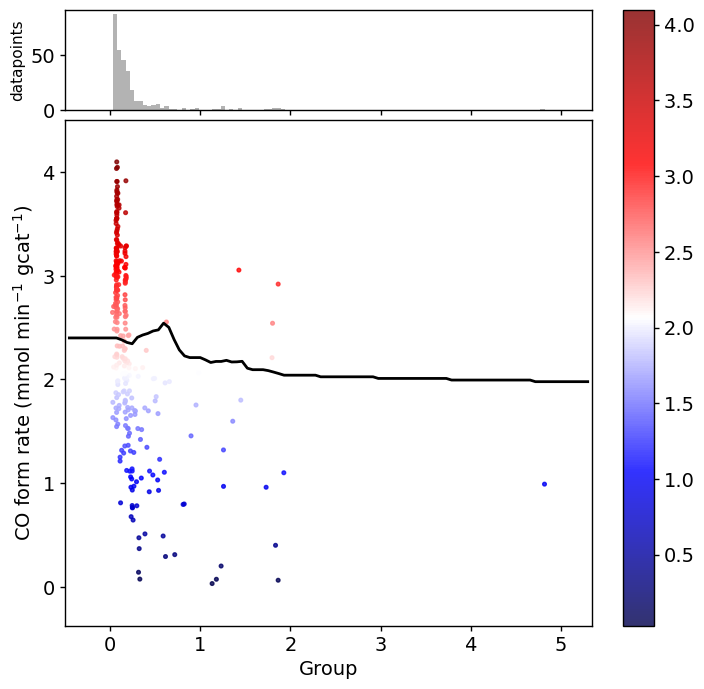

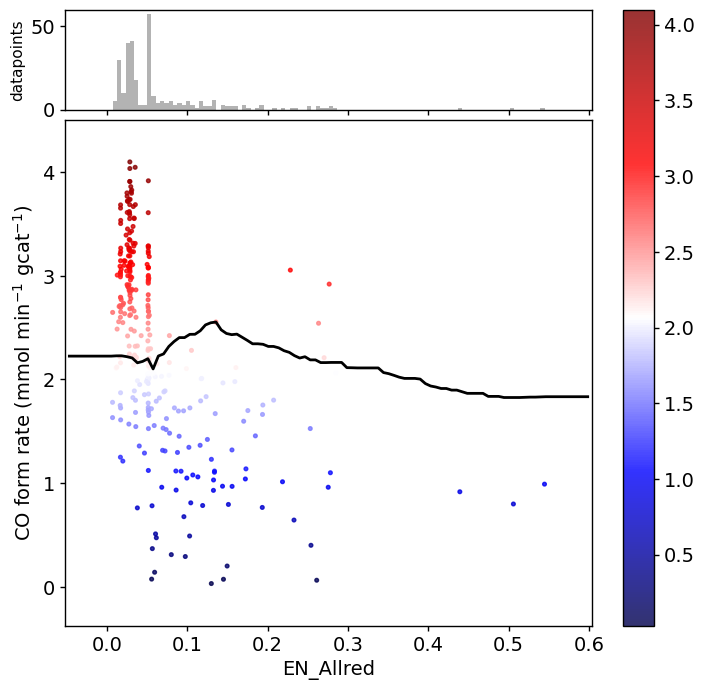

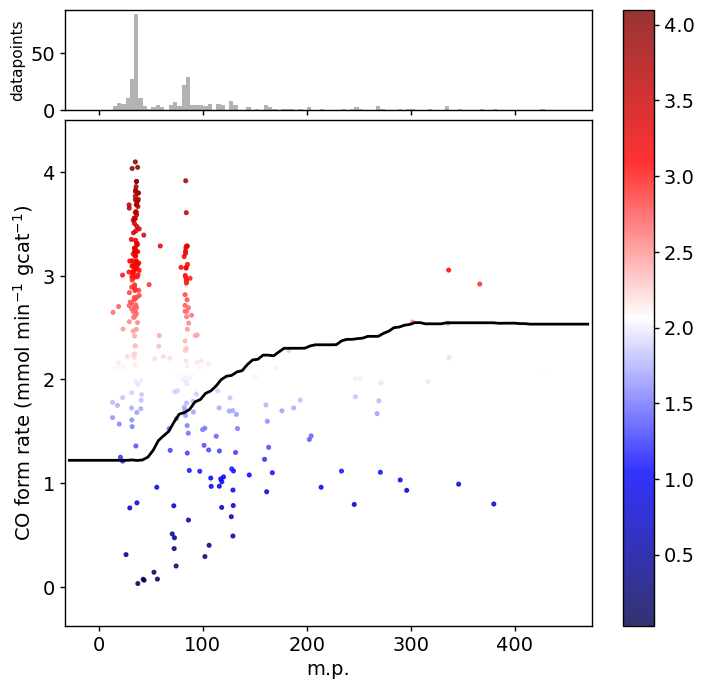

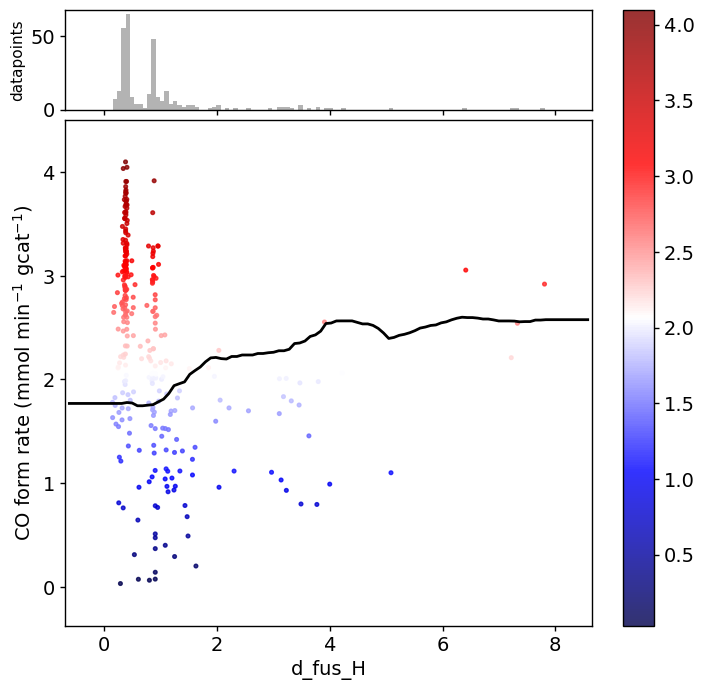

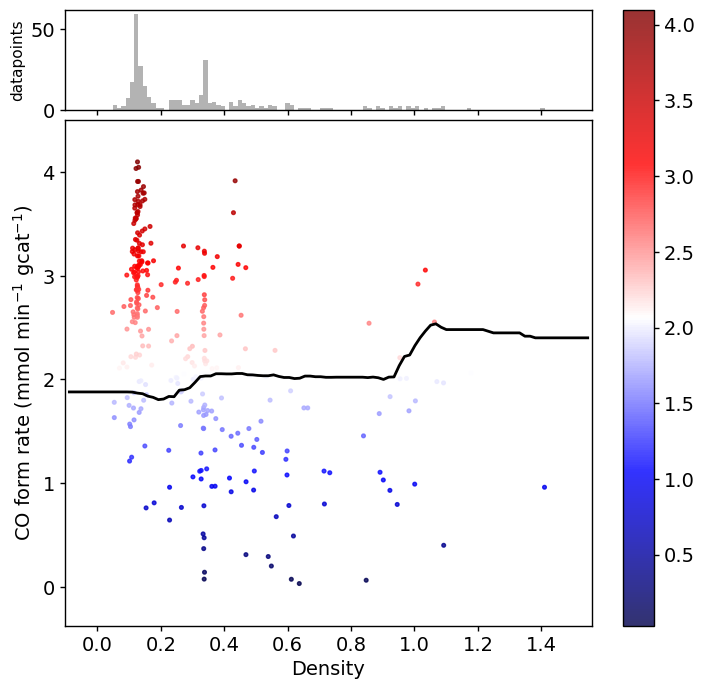

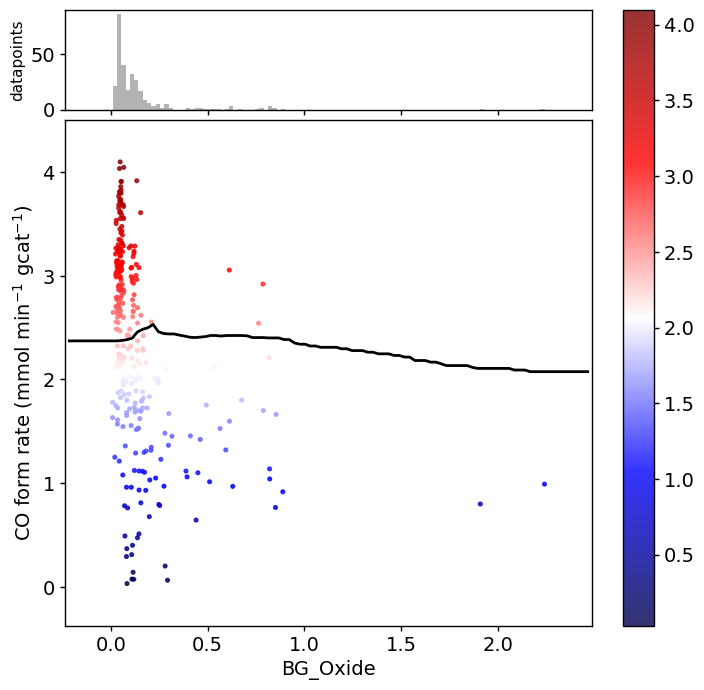

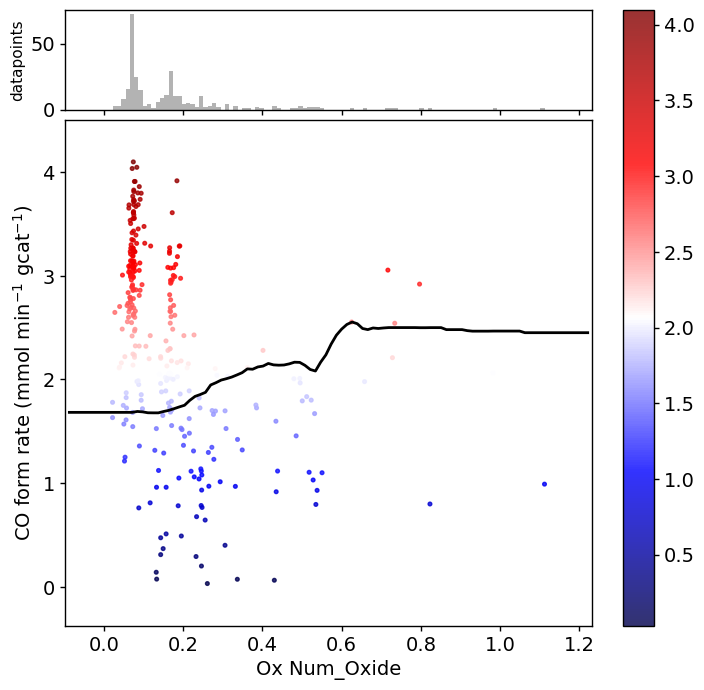

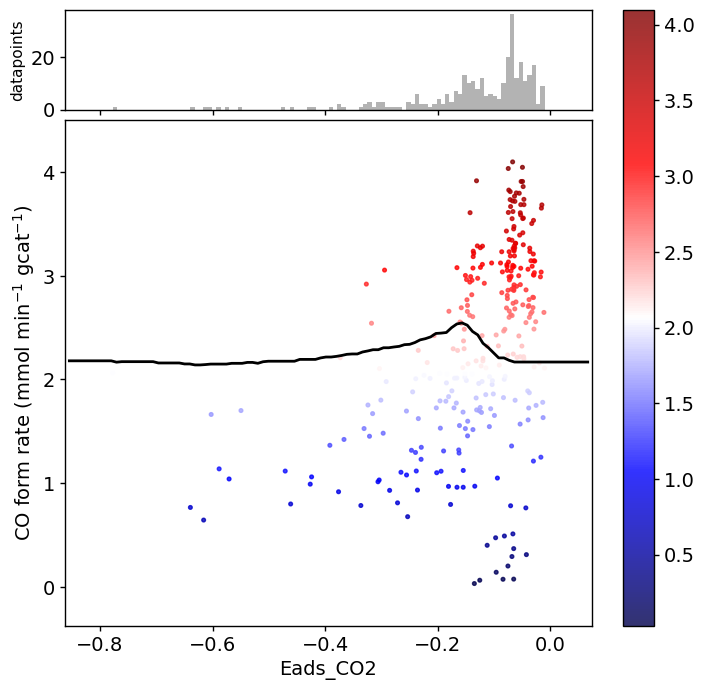

In [7]:
col_1 = '1way_PDP'
os.makedirs(f'{PATH}/{col_1}', exist_ok=True)

for i, s in enumerate(feat.columns):
    custom_oneway_pdp(
        i, feat, target, model, expand_rate=0.1, grid_resolution=100, cmap_color='seismic',
        max_wt=10, max_target='auto', min_target='auto', max_feat='auto', min_feat='auto', plot=True, number=False
        )
    plt.savefig(f'{PATH}/{col_1}/{col_1}_{s}.png', dpi=300, bbox_inches='tight')

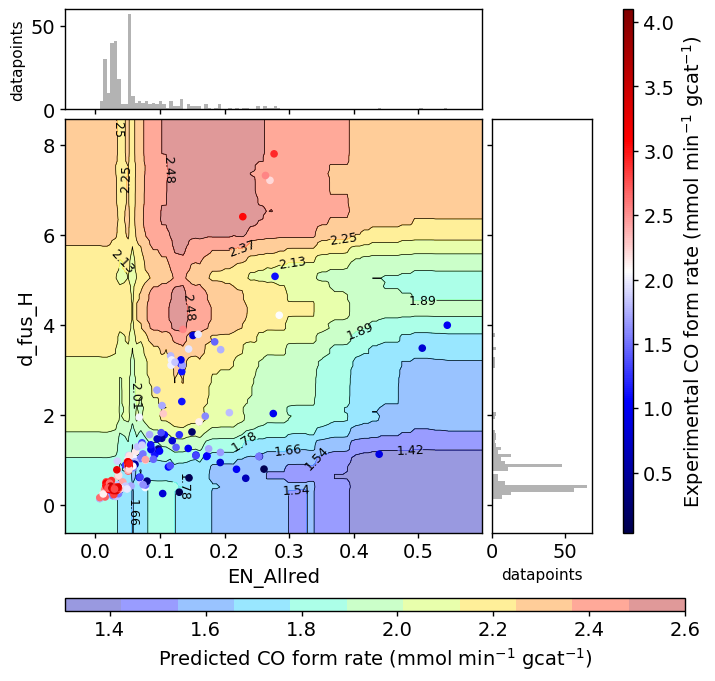

In [8]:
desc_cand_list = ['Group', 'EN_Allred', 'Ox Num_Precursor', 'Density', 'Eads_CO2', 'm.p.', 'BG_Oxide', 'd_fus_H']

pdp_cols = ['EN_Allred', 'd_fus_H']
col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

s =list(feat.columns).index(pdp_cols[0])
t =list(feat.columns).index(pdp_cols[1])

custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, line_color='black', cmap_color='seismic', contourf_color='jet', scatter=True, hist=True)
plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_cols[0]}_vs_{pdp_cols[1]}.png', dpi=600, bbox_inches = 'tight')

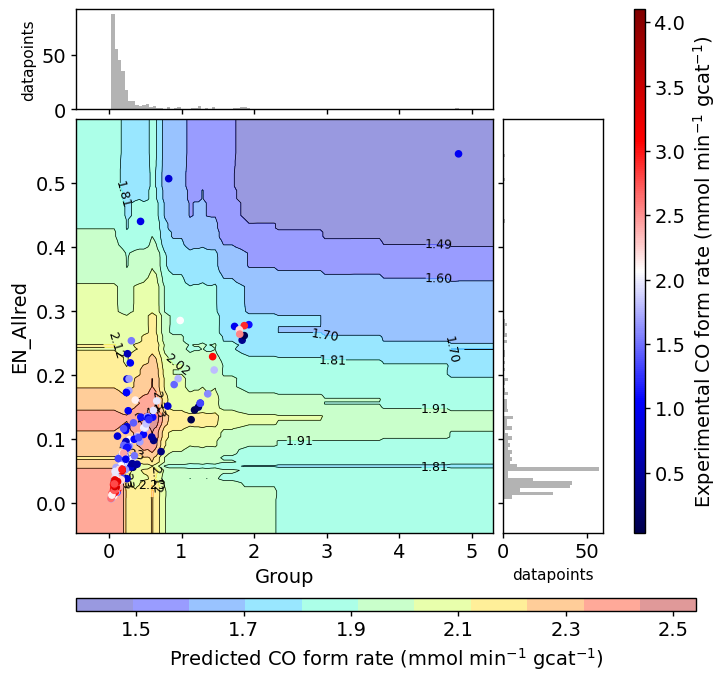

In [10]:
pdp_cols = ['Group', 'EN_Allred']
col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

s =list(feat.columns).index(pdp_cols[0])
t =list(feat.columns).index(pdp_cols[1])

custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, line_color='black', cmap_color='seismic', contourf_color='jet', scatter=True, hist=True)
plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_cols[0]}_vs_{pdp_cols[1]}_v2.png', dpi=600, bbox_inches = 'tight')

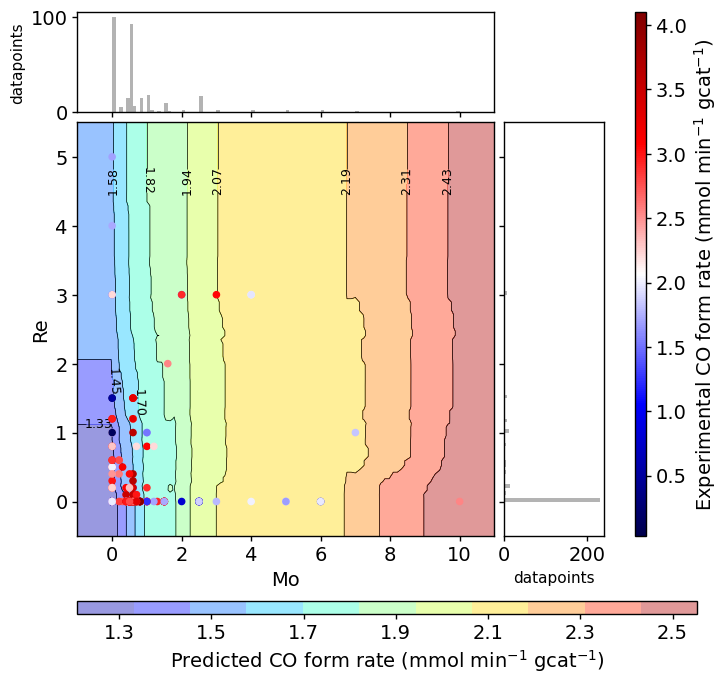

In [12]:
pdp_cols = ['Mo', 'Re']
col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

s =list(feat.columns).index(pdp_cols[0])
t =list(feat.columns).index(pdp_cols[1])

custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, line_color='black', cmap_color='seismic', contourf_color='jet', scatter=True, hist=True)
plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_cols[0]}_vs_{pdp_cols[1]}.png', dpi=600, bbox_inches = 'tight')